In [1]:
import os
import sys

sys.path.append("..")

import tqdm
import time
from copy import deepcopy
import numpy as np
import pandas as pd

import itertools
import random

# from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import check_random_state
from sklearn.preprocessing import normalize
from lightgbm import LGBMRanker
from sharp import ShaRP
from xai_ranking.utils import scores_to_ordering
from xai_ranking.preprocessing import preprocess_higher_education_data
from xai_ranking.scorers import higher_education_score
from mlresearch.utils import check_random_states, set_matplotlib_style

from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    hierarchical_ranking_explanation,
    lime_experiment,
    shap_experiment,
    sharp_experiment,
    # rank_lime_experiment,
    # participation_experiment,
)

from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity_all_neighbors,
)

RNG_SEED = 42
N_RUNS = 1

datasets = [
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "n_observations": 100,
    },
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "n_observations": 86,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
    },
]

xai_methods = [
    {
        "iterations": 1,
        "name": "LIME",
        "experiment": lime_experiment,
        "type": "score",
        "kwargs": {"mode": "regression"},  # classification, regression
    },
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "type": "score",
        "kwargs": {},
    },
    {
        "iterations": 1,
        "name": "ShaRP_RANK",
        "experiment": sharp_experiment,
        "type": "rank",
        "kwargs": {
            "qoi": "rank",
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
        },
    },
    {
        "iterations": 1,
        "name": "ShaRP_SCORE",
        "experiment": sharp_experiment,
        "type": "score",
        "kwargs": {
            "qoi": "rank_score",
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
        },
    },
    # {
    #     "iterations": 1,
    #     "name": "ShaRP_TOPK",
    #     "experiment": sharp_experiment,
    #     "kwargs": {
    #         "qoi": "top_k",
    #         "verbose": True,
    #         "sample_size": None,
    #         "measure": "shapley",
    #         "n_jobs": -1,
    #         "replace": True,
    #     },
    # },
    {
        "iterations": 1,
        "name": "HRE_DT",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "DT", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_LR",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "LR", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_OLS",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "OLS", "s": 10},  # DT, LR, OLS, PLS
    },
    {
        "iterations": 1,
        "name": "HRE_PLS",
        "type": "score",
        "experiment": hierarchical_ranking_explanation,
        "kwargs": {"model_type": "PLS", "s": 10},  # DT, LR, OLS, PLS
    },
    # {
    #     "iterations": 1,
    #     "name": "HIL_Shapley",
    #     "experiment": human_in_the_loop_experiment,
    #     "kwargs": {"upper_bound": 1, "lower_bound": None, "method_type": "shapley"},
    # },
    {
        "iterations": 1,
        "name": "HIL_Standardized-Shapley",
        "type": "std-score",
        "experiment": human_in_the_loop_experiment,
        "kwargs": {
            "upper_bound": 1,
            "lower_bound": None,
            "method_type": "standardized shapley",
        },
    },
    {
        "iterations": 1,
        "name": "HIL_Rank-Shapley",
        "experiment": human_in_the_loop_experiment,
        "type": "std-rank",
        "kwargs": {
            "upper_bound": 1,
            "lower_bound": None,
            "method_type": "rank-relevance shapley",
        },
    },
    # {
    #     "iterations": 1,
    #     "name": "RankLIME",
    #     "experiment": rank_lime_experiment,
    #     "kwargs": {
    #         "explanation_size": 3,
    #         "rank_similarity_coefficient": lambda x, y: kendalltau(x, y)[0],
    #         "individual_masking": True,
    #         "use_entry": 0,
    #         "use_pandas_where": False,
    #     },
    # },
    # {"iterations": 1, "name": "Participation", "experiment": participation_experiment},
]

def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/contributions/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

results = read_results_from_files()
        

# Calculate Euclidean distance from all items to all items

In [ ]:
for dataset in datasets:
    rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
    data = dataset["data"][0]
    for method in xai_methods:
        print(dataset["name"], " ", method["name"])
        res = results[dataset["name"]][method["name"]][0]

        # Euclidean
        result = explanation_sensitivity_all_neighbors(
            data, 
            res,
            rankings,
            measure="euclidean",
            threshold=None,
            normalization=False
        )
        
        euc_dist = []
        rank_dist = []
        feat_dist = []
        for index in range(data.shape[0]):
            # Euclidean distance of each item to each item
            measure_distances, rank_distances, feature_distances = result(row_idx=index)
            # print(measure_distances)
            # print(rank_distances)
            euc_dist.append(measure_distances.tolist())
            rank_dist.append(abs(rank_distances).tolist())
            feat_dist.append(feature_distances.tolist())

        # Kendall distance
        result = explanation_sensitivity_all_neighbors(
            data, 
            res,
            rankings,
            measure="kendall",
            threshold=None
        )
        
        kend_dist = []
        for index in range(data.shape[0]):
            # Kendall distance of each item to each item
            measure_distances, rank_distances, feature_distances = result(row_idx=index)
            kend_dist.append(measure_distances.tolist())

        
        # Save explanation distances
        result_fname = (
                f"results/sensitivity/correlations/_explanation_distances_{dataset['name']}_"
                f"{method['name']}.csv"
            )
        result_df = pd.DataFrame(euc_dist)
        result_df.to_csv(result_fname)
        # Save explanation distances (kendall)
        result_fname = (
                f"results/sensitivity/correlations/_explanation_distances_kendall_{dataset['name']}_"
                f"{method['name']}.csv"
            )
        result_df = pd.DataFrame(kend_dist)
        result_df.to_csv(result_fname)
        # Save ranks differences once (identical for all methods)
        result_fname = (
                f"results/sensitivity/correlations/_rank_distances_{dataset['name']}.csv"
            )
        if not os.path.isfile(result_fname):
            result_df = pd.DataFrame(rank_dist)
            result_df.to_csv(result_fname)
        # Save feature distances once (identical for all methods)
        result_fname = (
                f"results/sensitivity/correlations/_feature_distances_{dataset['name']}.csv"
            )
        if not os.path.isfile(result_fname):
            result_df = pd.DataFrame(feat_dist)
            result_df.to_csv(result_fname)

In [2]:
def read_corr_results_from_files():
    ranks_dict = {}
    features_dict = {}
    explanations_dict = {}
    explanations_kendall_dict = {}
    for cur_dataset in datasets:
        # Read rank and feature differences from file
        fname = (
            f"results/sensitivity/correlations/_rank_distances_"
            f"{cur_dataset['name']}.csv"
        )
        if os.path.isfile(fname):
                ranks_dict[cur_dataset["name"]] = pd.read_csv(fname, index_col=0)
        fname = (
            f"results/sensitivity/correlations/_feature_distances_"
            f"{cur_dataset['name']}.csv"
        )
        if os.path.isfile(fname):
                features_dict[cur_dataset["name"]] = pd.read_csv(fname, index_col=0)

        # Read explanation differences from files
        explanations_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            fname = (
                f"results/sensitivity/correlations/_explanation_distances_"
                f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
            )
            if os.path.isfile(fname):
                    explanations_dict[cur_dataset["name"]][cur_xai_method["name"]] = pd.read_csv(fname, index_col=0)

        # Read explanation differences from files
        explanations_kendall_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            fname = (
                f"results/sensitivity/correlations/_explanation_distances_kendall_"
                f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
            )
            if os.path.isfile(fname):
                    explanations_kendall_dict[cur_dataset["name"]][cur_xai_method["name"]] = pd.read_csv(fname, index_col=0)
    return ranks_dict, features_dict, explanations_dict, explanations_kendall_dict



In [3]:
ranks, features, explanations, explanations_kendall = read_corr_results_from_files()

In [4]:
# explanations

# Calculate the correlations

In [ ]:
cols = ["dataset", "method", "metric", "comparison", "correlation", "pvalue"]
df_correlations = pd.DataFrame(columns=cols)
df_correlations_kendall = pd.DataFrame(columns=cols)
for cur_dataset in datasets:
    for cur_xai_method in xai_methods:
        print(cur_dataset["name"], " ", cur_xai_method["name"])
        
        # Euclidean
        spearman_rank = spearmanr(explanations[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),ranks[cur_dataset["name"]].values.flatten())
        pearson_rank = pearsonr(explanations[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),ranks[cur_dataset["name"]].values.flatten())
        # print(spearman_rank.statistic, " ", pearson_rank.statistic)
        # print(spearman_rank.pvalue, " ", pearson_rank.pvalue)
        df_correlations.loc[df_correlations.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Spearman", "ranks", spearman_rank.statistic, spearman_rank.pvalue]
        df_correlations.loc[df_correlations.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Pearson", "ranks", pearson_rank.statistic, pearson_rank.pvalue]

        spearman_features = spearmanr(explanations[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),features[cur_dataset["name"]].values.flatten())
        pearson_features = pearsonr(explanations[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),features[cur_dataset["name"]].values.flatten())
        # print(spearman_features.statistic)
        # print(spearman_features.pvalue)
        df_correlations.loc[df_correlations.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Spearman", "features", spearman_features.statistic, spearman_features.pvalue]
        df_correlations.loc[df_correlations.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Pearson", "features", pearson_features.statistic, pearson_features.pvalue]

        # Kendall
        spearman_rank = spearmanr(explanations_kendall[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),ranks[cur_dataset["name"]].values.flatten())
        pearson_rank = pearsonr(explanations_kendall[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),ranks[cur_dataset["name"]].values.flatten())
        # print(spearman_rank.statistic, " ", pearson_rank.statistic)
        # print(spearman_rank.pvalue, " ", pearson_rank.pvalue)
        df_correlations_kendall.loc[df_correlations_kendall.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Spearman", "ranks", spearman_rank.statistic, spearman_rank.pvalue]
        df_correlations_kendall.loc[df_correlations_kendall.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Pearson", "ranks", pearson_rank.statistic, pearson_rank.pvalue]

        spearman_features = spearmanr(explanations_kendall[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),features[cur_dataset["name"]].values.flatten())
        pearson_features = pearsonr(explanations_kendall[cur_dataset["name"]][cur_xai_method["name"]].values.flatten(),features[cur_dataset["name"]].values.flatten())
        # print(spearman_features.statistic)
        # print(spearman_features.pvalue)
        df_correlations_kendall.loc[df_correlations_kendall.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Spearman", "features", spearman_features.statistic, spearman_features.pvalue]
        df_correlations_kendall.loc[df_correlations_kendall.shape[0]] = [cur_dataset["name"], cur_xai_method["name"], "Pearson", "features", pearson_features.statistic, pearson_features.pvalue]

df_correlations_kendall

In [5]:
sns.scatterplot(data=df_correlations[(df_correlations["metric"]=="Spearman") & (df_correlations["comparison"] == "ranks")], x="method", y="correlation", hue="dataset")
plt.xticks(rotation=90)
plt.savefig(
    f"results/sensitivity/sensitivity-plots/correlations/explanationNrank-spearman-EUCLIDEAN.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )
plt.show()

NameError: name 'df_correlations' is not defined

In [ ]:
sns.scatterplot(data=df_correlations[(df_correlations["metric"]=="Spearman") & (df_correlations["comparison"] == "features")], x="method", y="correlation", hue="dataset")
plt.xticks(rotation=90)
plt.savefig(
    f"results/sensitivity/sensitivity-plots/correlations/explanationNfeatures-spearman-EUCLIDEAN.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )
plt.show()

In [ ]:
sns.scatterplot(data=df_correlations_kendall[(df_correlations_kendall["metric"]=="Spearman") & (df_correlations_kendall["comparison"] == "ranks")], x="method", y="correlation", hue="dataset")
plt.xticks(rotation=90)
plt.savefig(
    f"results/sensitivity/sensitivity-plots/correlations/explanationNrank-spearman-KENDALL.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )
plt.show()

In [ ]:
sns.scatterplot(data=df_correlations_kendall[(df_correlations_kendall["metric"]=="Spearman") & (df_correlations_kendall["comparison"] == "features")], x="method", y="correlation", hue="dataset")
plt.xticks(rotation=90)
plt.savefig(
    f"results/sensitivity/sensitivity-plots/correlations/explanationNfeatures-spearman-KENDALL.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )
plt.show()

# Sensitivity Plots
## Euclidean

In [11]:
from os.path import isfile
set_matplotlib_style(font_size=24)

new_rcparams = {
    "axes.spines.left": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
}
plt.rcParams.update(new_rcparams)

In [5]:
for cur_dataset in datasets:
    print(cur_dataset["name"])
    print(ranks[cur_dataset["name"]].shape[0])

Higher Education
1397
ATP
86
CSRank
189
Synthetic_0
2000
Synthetic_1
2000
Synthetic_2
2000


In [6]:
for cur_dataset in datasets:
    print(cur_dataset["name"])
    dataset_len = ranks[cur_dataset["name"]].shape[0]
    alpha = 0.1 if dataset_len < 200 else 0.01
    for cur_xai_method in xai_methods:

        if isfile(f"results/sensitivity/sensitivity-plots/total/sensitivity-scatterplot-euclidean-{cur_dataset["name"]}-{cur_xai_method["name"]}.png"):
            continue

        l = []
        print(cur_dataset["name"], " ", cur_xai_method["name"])
        for index, row in ranks[cur_dataset["name"]].iterrows():
            temp = pd.DataFrame()        
            temp['Explanation distance'] = explanations[cur_dataset["name"]][cur_xai_method["name"]].iloc[[index]].T
            temp['Absolute Rank distance'] = ranks[cur_dataset["name"]].iloc[[index]].T
            temp['Feature distance'] = features[cur_dataset["name"]].iloc[[index]].T
            l.append(temp)

        df = pd.concat(l)
        sns.scatterplot(data=df, x="Explanation distance", y="Absolute Rank distance", hue="Feature distance", alpha=alpha, edgecolor="none")
        leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        for lh in leg.legend_handles: 
            lh.set_alpha(1)

        plt.savefig(
            f"results/sensitivity/sensitivity-plots/total/sensitivity-scatterplot-euclidean-{cur_dataset["name"]}-{cur_xai_method["name"]}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
            transparent=True
        )
        plt.close()


Higher Education
ATP
CSRank
Synthetic_0
Synthetic_1
Synthetic_2
Synthetic_2   HRE_PLS
Synthetic_2   HIL_Standardized-Shapley
Synthetic_2   HIL_Rank-Shapley


Higher Education


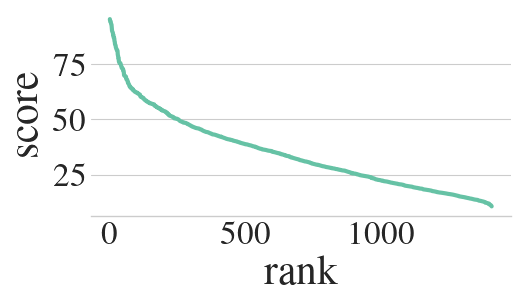

ATP


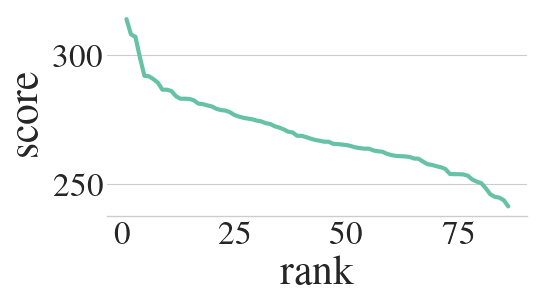

CSRank


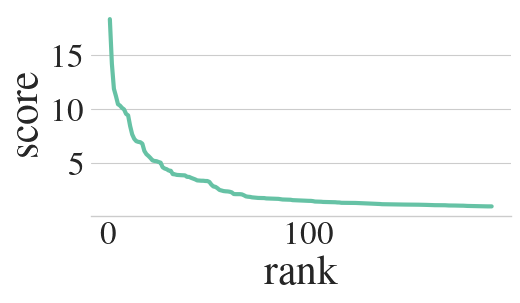

Synthetic_0


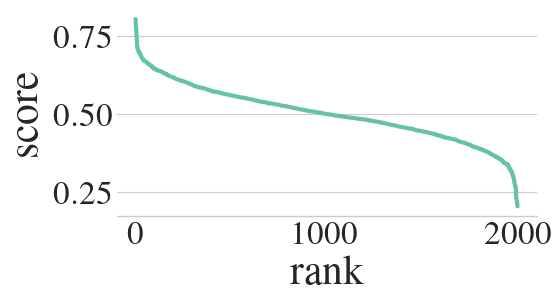

Synthetic_1


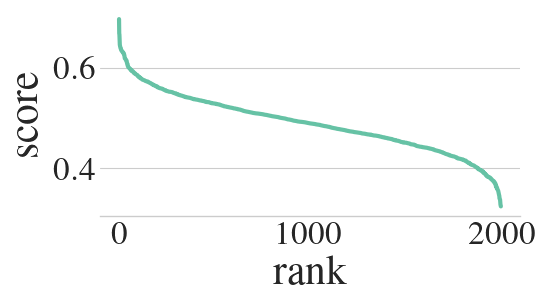

Synthetic_2


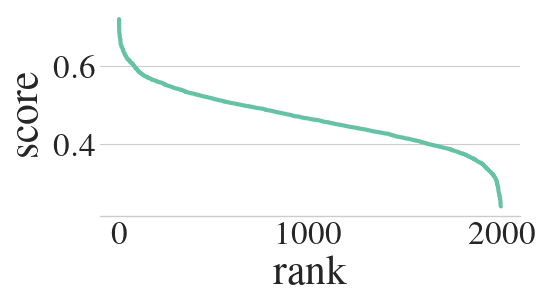

In [12]:
for dataset in datasets:
    print(dataset["name"])
    df = pd.DataFrame()
    df['rank'] = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
    if dataset["name"] == "ATP":
        df['score'] = dataset["scorer"](dataset["data"][0]).values
    else:
        df['score'] = dataset["scorer"](dataset["data"][0])
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 2.5), sharey='row')
    ax = sns.lineplot(data=df, x="rank", y="score", linewidth = 3, c='#66c2a5')
    ax.set_ylabel("score")
    ax.set_xlabel("rank")
    plt.grid(axis="x")

    fig.savefig(
        f"results/rank-vs-score-linechart-{dataset["name"]}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )

    plt.show()

In [ ]:
percentage = 0.1
ran = 1
for cur_dataset in datasets:
    dataset_len = ranks[cur_dataset["name"]].shape[0]
    threshold = percentage * dataset_len
    for cur_xai_method in xai_methods:
        print(cur_dataset["name"], " ", cur_xai_method["name"])
        for index, row in ranks[cur_dataset["name"]].iterrows():
            if ran in [int(num/10*dataset_len) for num in range(1,10,1)]:
                print(index)
                temp = pd.DataFrame()        
                temp['Explanation distance'] = explanations[cur_dataset["name"]][cur_xai_method["name"]].iloc[[index]].T
                temp['Absolute Rank distance'] = ranks[cur_dataset["name"]].iloc[[index]].T
                temp['Feature distance'] = features[cur_dataset["name"]].iloc[[index]].T
                sns.scatterplot(data=temp, x="Explanation distance", y="Absolute Rank distance", hue="Feature distance")
                leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                # plt.title(f'{method} and {dataset["name"]} and rank={plot_idx}')
                # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
                plt.savefig(
                f"results/sensitivity/sensitivity-plots/euclidean/sensitivity-scatterplot-{cur_dataset["name"]}-{cur_xai_method["name"]}-{index}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
                plt.show()
                # plt.clf()
            ran+=1
        ran=1

## Kendall

In [ ]:
percentage = 0.1
ran = 1
for cur_dataset in datasets:
    dataset_len = ranks[cur_dataset["name"]].shape[0]
    threshold = percentage * dataset_len
    for cur_xai_method in xai_methods:
        print(cur_dataset["name"], " ", cur_xai_method["name"])
        for index, row in ranks[cur_dataset["name"]].iterrows():
            if ran in [int(num/10*dataset_len) for num in range(1,10,1)]:
                print(index)
                temp = pd.DataFrame()        
                temp['Explanation distance'] = explanations_kendall[cur_dataset["name"]][cur_xai_method["name"]].iloc[[index]].T
                temp['Absolute Rank distance'] = ranks[cur_dataset["name"]].iloc[[index]].T
                temp['Feature distance'] = features[cur_dataset["name"]].iloc[[index]].T
                sns.scatterplot(data=temp, x="Explanation distance", y="Absolute Rank distance", hue="Feature distance")
                leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                # plt.title(f'{method} and {dataset["name"]} and rank={plot_idx}')
                # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
                plt.savefig(
                f"results/sensitivity/sensitivity-plots/kendall/sensitivity-scatterplot-{cur_dataset["name"]}-{cur_xai_method["name"]}-{index}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
                plt.show()
                # plt.clf()
            ran+=1
        ran=1